In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, mean_squared_error, RocCurveDisplay #plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.exceptions import ConvergenceWarning

from xgboost import XGBRegressor
!pip install catboost
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [148]:
from sklearn.linear_model import LogisticRegression

In [149]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 1000)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.float_format", lambda x:  "%.4f" % x)

In [150]:
# Veriyi okuma
df = pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.9000,0,yes,southwest,16884.9240
1,18,male,33.7700,1,no,southeast,1725.5523
2,28,male,33.0000,3,no,southeast,4449.4620
3,33,male,22.7050,0,no,northwest,21984.4706
4,32,male,28.8800,0,no,northwest,3866.8552


In [151]:
# Veriyi inceleme
def check_df(dataframe, head=5):
  print("######### SHAPE ###########")
  print(dataframe.shape)
  print("######## Types #######")
  print(dataframe.dtypes)
  print("######## HEAD #########")
  print(dataframe.head(head))
  print("######### TAİL ########")
  print(dataframe.tail(head))
  print("######## Boş Değerler #####")
  print(dataframe.isnull().sum())

check_df(df)

######### SHAPE ###########
(1338, 7)
######## Types #######
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
######## HEAD #########
   age     sex     bmi  children smoker     region    charges
0   19  female 27.9000         0    yes  southwest 16884.9240
1   18    male 33.7700         1     no  southeast  1725.5523
2   28    male 33.0000         3     no  southeast  4449.4620
3   33    male 22.7050         0     no  northwest 21984.4706
4   32    male 28.8800         0     no  northwest  3866.8552
######### TAİL ########
      age     sex     bmi  children smoker     region    charges
1333   50    male 30.9700         3     no  northwest 10600.5483
1334   18  female 31.9200         0     no  northeast  2205.9808
1335   18  female 36.8500         0     no  southeast  1629.8335
1336   21  female 25.8000         0     no  southwest  2007.9450
1337   61  female 29.0700         0    y

In [152]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0000,39.2070,14.0500,18.0000,27.0000,39.0000,51.0000,64.0000
bmi,1338.0000,30.6634,6.0982,15.9600,26.2963,30.4000,34.6938,53.1300
children,1338.0000,1.0949,1.2055,0.0000,0.0000,1.0000,2.0000,5.0000
charges,1338.0000,13270.4223,12110.0112,1121.8739,4740.2872,9382.0330,16639.9125,63770.4280


In [153]:
# Verideki değişkenlerin analizi
def grab_col_names(dataframe, cat_th=10, car_th=20):
  """
  *******
  Parametreler
  ------
    dataframe : dataframe
       Değişken isimleri alınmak istenen DataFrame'dir.

    cat_th :  int / float
        Numerik fakat kategorik olan değişkenler için sınıf eşiği

    car_th : int / float
      Kategorik fakat kardinal olan değişkenler için sınıf eşiği


  Returns
   ------
    cath_cols : list
         Kategorik değişken listesi
    num_cols : list
        Numerik değişken listesi
    cat_but_car :
        Kategorik gözüken fakat kardinal olan değişken listesi


  Notes :
  -----
    cath_cols + num_cols + cat_but_car = Toplam Değişken Sayısı
    -----------
    """
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                 dataframe[col].dtypes != "O"]
  cat_but_car = [col for col in dataframe.columns if
                 dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
  num_cols = [col for col in num_cols if col not in num_but_cat]


  print(f"Obervations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f"cat_cols: {len(cat_cols)}")
  print(f"num_cols: {len(num_cols)}")
  print(f"cat_but_car: {len(cat_but_car)}")
  print(f"num_but_cat: {len(num_but_cat)}")

  return cat_cols, num_cols, cat_but_car

In [154]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Obervations: 1338
Variables: 7
cat_cols: 4
num_cols: 3
cat_but_car: 0
num_but_cat: 1


In [155]:
# Kategorik Değişkenler İncelemesi
def cat_summary(dataframe,col_name,plot=False):
    print(pd.DataFrame({col_name:dataframe[col_name].value_counts(),"Ratio":100*dataframe[col_name].value_counts()/len(dataframe)}))
    if plot:
        sns.countplot(x=dataframe[col_name],data=dataframe)
        plt.show(block=True)
        print("**********************************************************************************")

        sex   Ratio
male    676 50.5232
female  662 49.4768


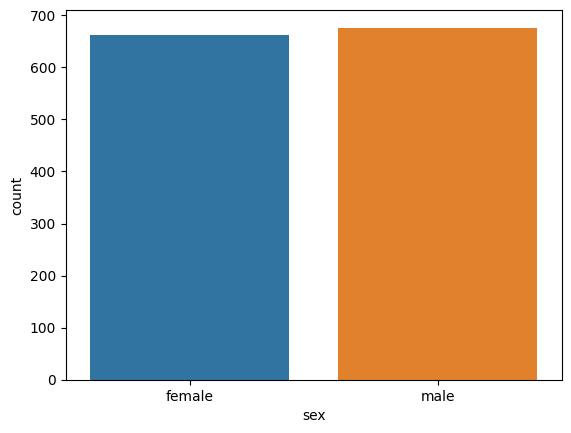

**********************************************************************************
     smoker   Ratio
no     1064 79.5217
yes     274 20.4783


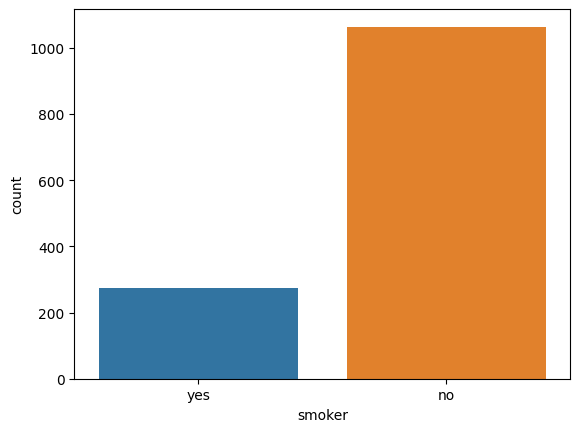

**********************************************************************************
           region   Ratio
southeast     364 27.2048
southwest     325 24.2900
northwest     325 24.2900
northeast     324 24.2152


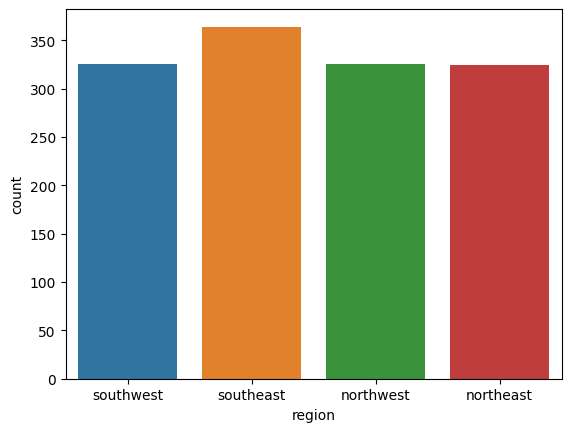

**********************************************************************************
   children   Ratio
0       574 42.8999
1       324 24.2152
2       240 17.9372
3       157 11.7339
4        25  1.8685
5        18  1.3453


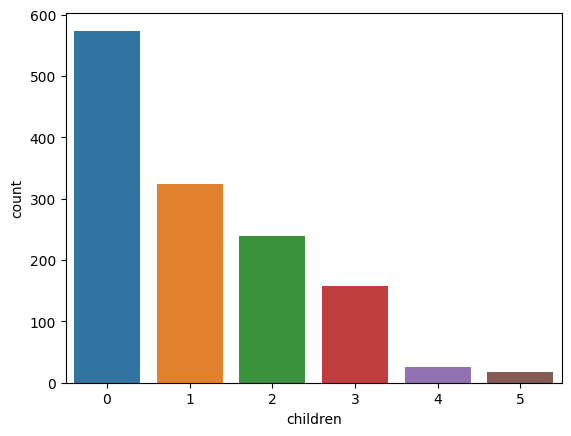

**********************************************************************************


In [156]:
for col in cat_cols:
    cat_summary(df,col,plot=True)

In [157]:
# Sayısal Değişkenlerin İncelenmesi
def num_summary(dataframe,numerical_col,plot=False):
    quantiles=[0.05,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.95,0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
        print("**********************************************************************************")

count   1338.0000
mean      39.2070
std       14.0500
min       18.0000
5%        18.0000
10%       19.0000
20%       24.0000
30%       29.0000
40%       34.0000
50%       39.0000
60%       44.0000
70%       49.0000
80%       54.0000
90%       59.0000
95%       62.0000
99%       64.0000
max       64.0000
Name: age, dtype: float64


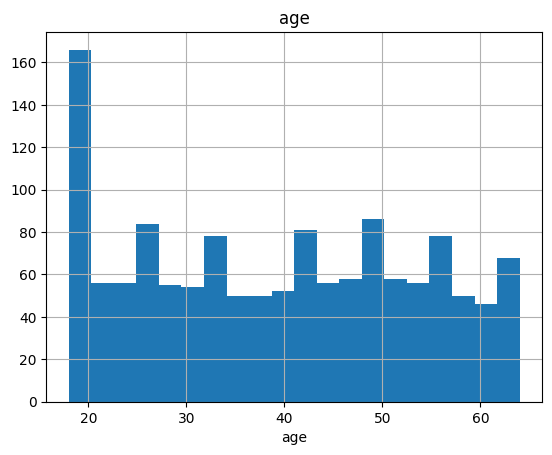

**********************************************************************************
count   1338.0000
mean      30.6634
std        6.0982
min       15.9600
5%        21.2560
10%       22.9900
20%       25.3260
30%       27.3600
40%       28.7970
50%       30.4000
60%       32.0320
70%       33.6600
80%       35.8600
90%       38.6195
95%       41.1060
99%       46.4079
max       53.1300
Name: bmi, dtype: float64


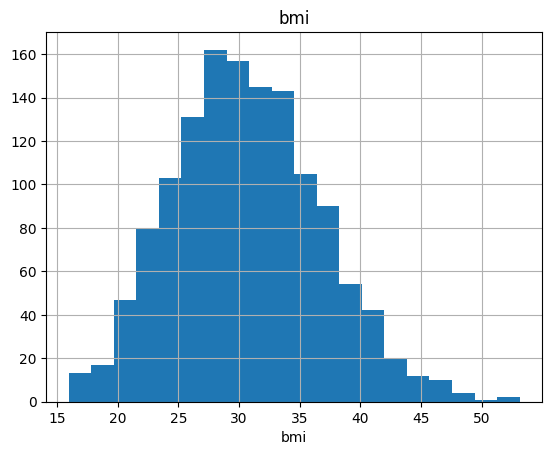

**********************************************************************************
count    1338.0000
mean    13270.4223
std     12110.0112
min      1121.8739
5%       1757.7534
10%      2346.5336
20%      3991.5757
30%      5484.8468
40%      7369.0527
50%      9382.0330
60%     11399.8572
70%     13767.8753
80%     20260.6264
90%     34831.7197
95%     41181.8278
99%     48537.4807
max     63770.4280
Name: charges, dtype: float64


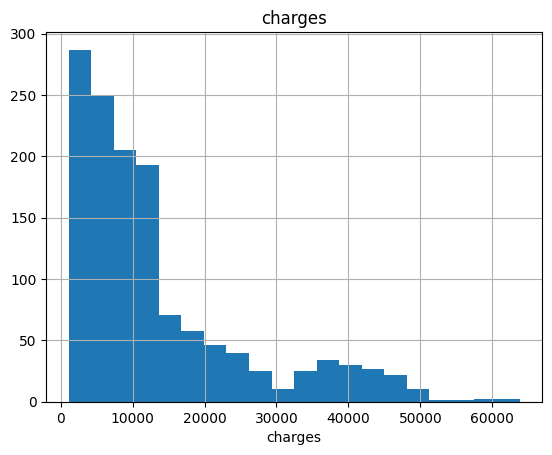

**********************************************************************************


In [158]:
for col in num_cols:
    num_summary(df,col,plot=True)

In [159]:
# Hedef değişken kırılımında kategorik değişkenlerin analizi
def target_summary_with_cat(dataframe, target, cat_cols):
  print(pd.DataFrame({"Target_Mean": dataframe.groupby(cat_cols)[target].mean()}), end="\n\n\n")

In [160]:
for col in cat_cols:
  target_summary_with_cat(df, "charges", col)

        Target_Mean
sex                
female   12569.5788
male     13956.7512


        Target_Mean
smoker             
no        8434.2683
yes      32050.2318


           Target_Mean
region                
northeast   13406.3845
northwest   12417.5754
southeast   14735.4114
southwest   12346.9374


          Target_Mean
children             
0          12365.9756
1          12731.1718
2          15073.5637
3          15355.3184
4          13850.6563
5           8786.0352




([<matplotlib.patches.Wedge at 0x793a88539ba0>,
 [Text(0.8726887788136719, 0.6696374357312337, 'no'),
  Text(-0.8726887161176866, -0.6696375174382512, 'yes')],
 [Text(0.47601206117109374, 0.36525678312612747, '20.8%'),
  Text(-0.47601202697328354, -0.3652568276935915, '79.2%')])

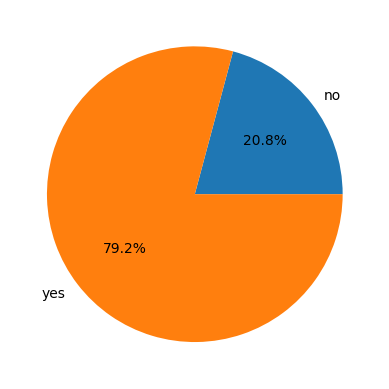

In [161]:
# Sigara içen ile içmeyen kişilerin masraflarının incelenmesi
smoker_charges=df.groupby("smoker")["charges"].mean()
plt.pie(smoker_charges.values,labels=smoker_charges.index,autopct="%1.1f%%")

Text(0.5, 1.0, 'Bölgelere göre sigara içilme miktarları')

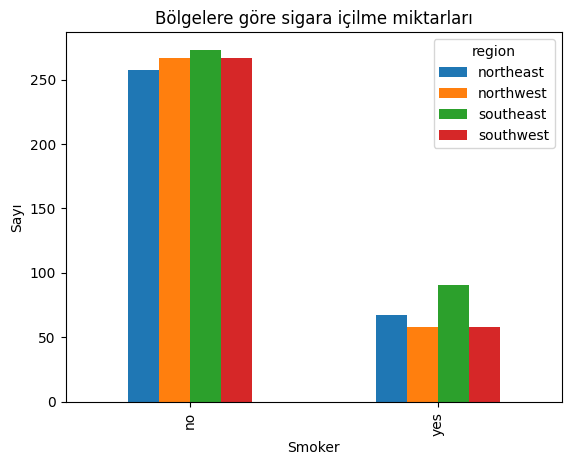

In [162]:
# Bölgelere göre sigara içilme miktarlarının incelenmesi
smoker_region=df.groupby("smoker")["region"].value_counts().unstack()
smoker_region.plot(kind="bar")
plt.xlabel("Smoker")
plt.ylabel("Sayı")
plt.title("Bölgelere göre sigara içilme miktarları")

([<matplotlib.patches.Wedge at 0x793a834d5a80>,
 [Text(0.0159304664828703, 1.099884639513453, 'female'),
  Text(-0.015930466482870678, -1.099884639513453, 'male')],
 [Text(0.00868934535429289, 0.599937076098247, '49.5%'),
  Text(-0.008689345354293096, -0.599937076098247, '50.5%')])

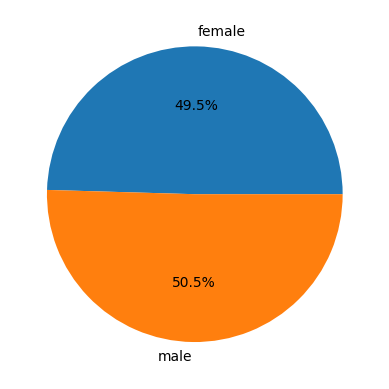

In [163]:
# Vücut kitle endeksi ile cinsiyet arasındaki ilişkinin incelenmesi
sex_bmi=df.groupby("sex")["bmi"].mean()
plt.pie(sex_bmi.values,labels=sex_bmi.index,autopct="%1.1f%%")

Text(0.5, 1.0, 'Bölgelere göre çocuk sayısı')

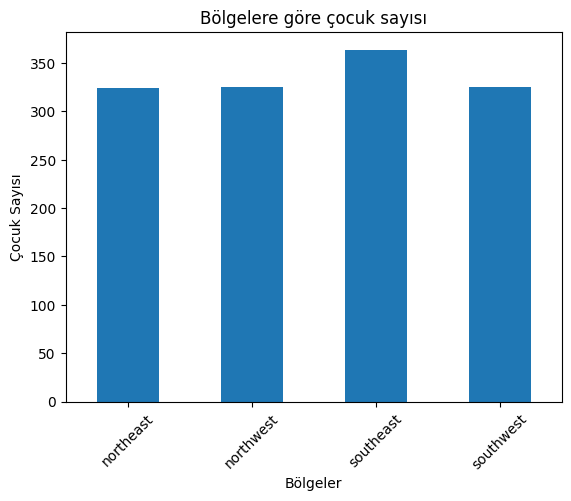

In [164]:
# Bölgelere göre çocuk sayısının incelenmesi
region_chd=df.groupby("region")["children"].count()
region_chd.plot(kind="bar")
plt.xticks(rotation=45)
plt.xlabel("Bölgeler")
plt.ylabel("Çocuk Sayısı")
plt.title("Bölgelere göre çocuk sayısı")

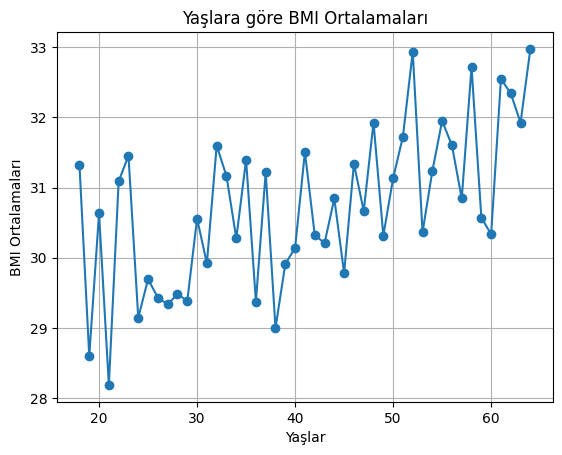

In [165]:
# Yaş ve vücut kitle endeksi arasındaki ilişkinin incelenmesi
age_bmi = df.groupby("age")["bmi"].mean()
plt.plot(age_bmi.index, age_bmi.values, marker="o")
plt.xlabel("Yaşlar")
plt.ylabel("BMI Ortalamaları")
plt.title("Yaşlara göre BMI Ortalamaları")
plt.grid(True)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5')])

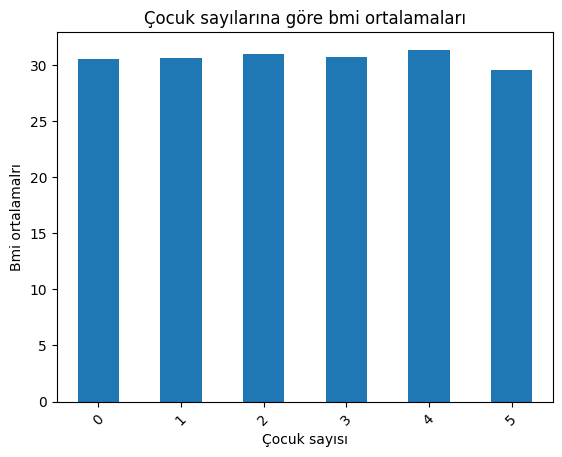

In [166]:
# Bmi ile çocuk sayısı arasındaki ilişkinin incelenmesi
ch_bmi=df.groupby("children")["bmi"].mean()
ch_bmi.plot(kind="bar")
plt.xlabel("Çocuk sayısı")
plt.ylabel("Bmi ortalamalrı")
plt.title("Çocuk sayılarına göre bmi ortalamaları")
plt.xticks(rotation=45)

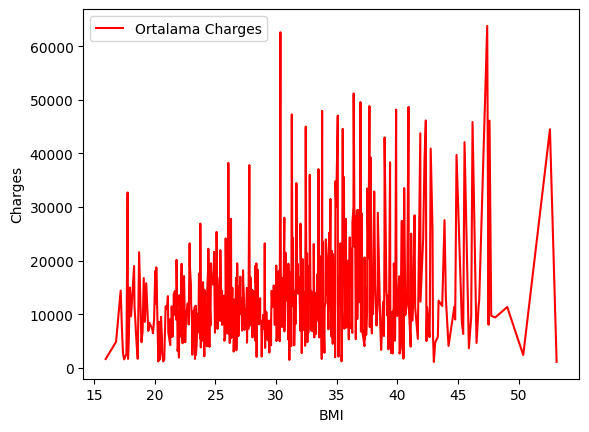

In [167]:
# Bmi ile charges arasındaki ilişkinin incelenmesi
charges_mean = df.groupby("bmi")["charges"].mean()
plt.plot(charges_mean.index, charges_mean.values, color="red", label="Ortalama Charges")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.legend()

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '(no, northeast)'),
  Text(1, 0, '(no, northwest)'),
  Text(2, 0, '(no, southeast)'),
  Text(3, 0, '(no, southwest)'),
  Text(4, 0, '(yes, northeast)'),
  Text(5, 0, '(yes, northwest)'),
  Text(6, 0, '(yes, southeast)'),
  Text(7, 0, '(yes, southwest)')])

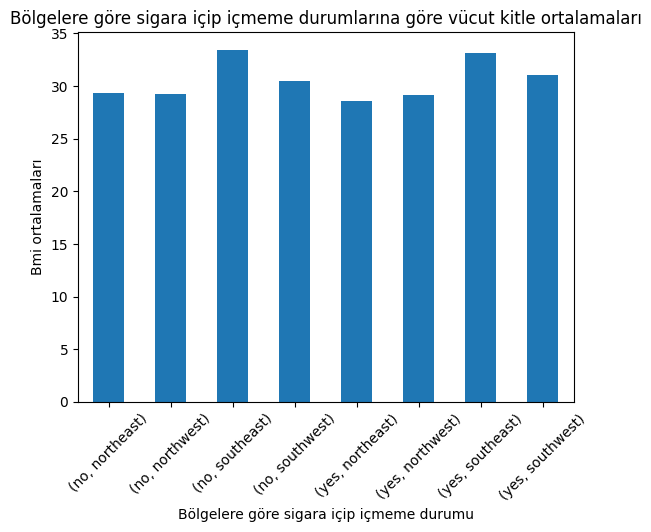

In [168]:
# Bölgelere ve sigara içip içilmediğine göre verilerin gruplanıp bmi ortalamalarının incelenmesi
smoker_region_bmi=df.groupby(["smoker","region"])["bmi"].mean()
smoker_region_bmi.plot(kind="bar")
plt.xlabel("Bölgelere göre sigara içip içmeme durumu")
plt.ylabel("Bmi ortalamaları")
plt.title("Bölgelere göre sigara içip içmeme durumlarına göre vücut kitle ortalamaları")
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Sigara kullanma durumuna göre bmi ortalamaları')

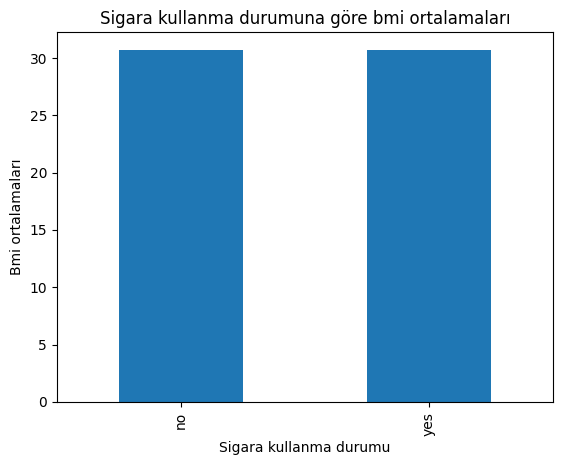

In [169]:
# Sigara kullanma durumuna göre bmi ortalamalarının incelenmesi
smoker_bmi=df.groupby("smoker")["bmi"].mean()
smoker_bmi.plot(kind="bar")
plt.xlabel("Sigara kullanma durumu")
plt.ylabel("Bmi ortalamaları")
plt.title("Sigara kullanma durumuna göre bmi ortalamaları")

Text(0.5, 1.0, 'Sigara kullanma durumuna göre yaş ortalamaları')

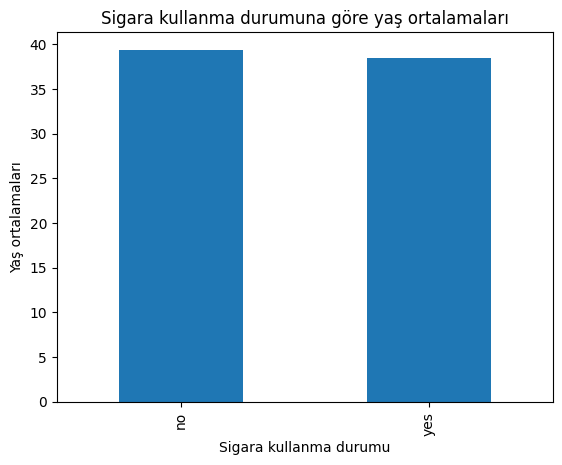

In [170]:
# Sigara kullanımı ile yaş ortalamasının arasındaki ilişkinin incelenmesi
age_smoker=df.groupby("smoker")["age"].mean()
age_smoker.plot(kind="bar")
plt.xlabel("Sigara kullanma durumu")
plt.ylabel("Yaş ortalamaları")
plt.title("Sigara kullanma durumuna göre yaş ortalamaları")

In [171]:
# Bmi'de aykırı değerlerin olup olmamasının incelenmesi
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0000,39.2070,14.0500,18.0000,27.0000,39.0000,51.0000,64.0000
bmi,1338.0000,30.6634,6.0982,15.9600,26.2963,30.4000,34.6938,53.1300
children,1338.0000,1.0949,1.2055,0.0000,0.0000,1.0000,2.0000,5.0000
charges,1338.0000,13270.4223,12110.0112,1121.8739,4740.2872,9382.0330,16639.9125,63770.4280


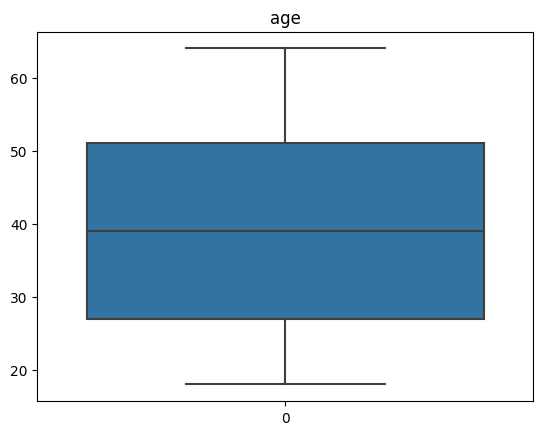

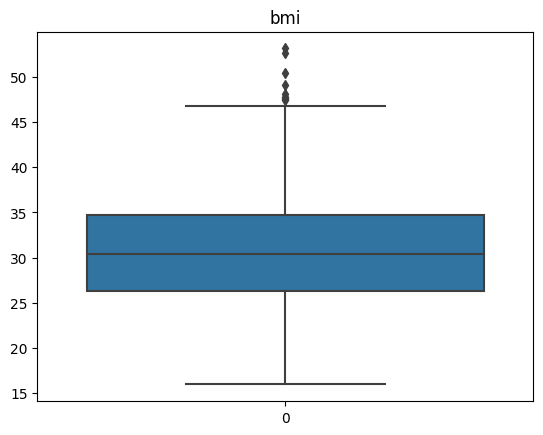

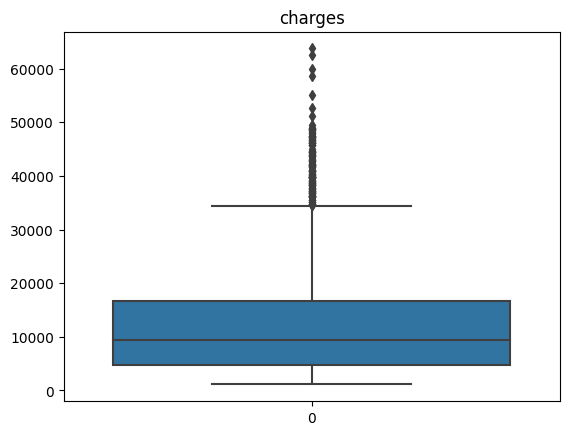

In [172]:
for col in num_cols:
    plt.title(col)
    sns.boxplot(df[col])
    plt.show(block=True)

In [173]:
# Eşik Değerlerini Belirleyen Fonksiyon
def outlier_treshold(dataframe, col_name, q1=0.25, q3=0.75):
  quantile1 = dataframe[col_name].quantile(q1)
  quantile3 = dataframe[col_name].quantile(q3)
  ıqr = quantile3 - quantile1
  up_limit = quantile3 + 1.5 * ıqr
  low_limit = quantile1 - 1.5 * ıqr
  return low_limit, up_limit

In [174]:
# Aykırı Değerin var olup olmamasını kontrol eden fonksiyon
def check_outlier(dataframe, col_name):
  low, up = outlier_treshold(dataframe, col_name)

  if dataframe[(dataframe[col_name] > up) | (dataframe[col_name] < low) ].any(axis=None):
    return True
  else :
    return False

In [175]:
for col in num_cols:
  print(col, check_outlier(df, col))

age False
bmi True
charges True


In [176]:
# Aykırı değerlerin baskılanması
def replace_with_thresholds(dataframe,variable,q1=0.25,q3=0.75):
    low_limit,up_limit=outlier_thresholds(dataframe,variable,q1,q3)
    dataframe.loc[(dataframe[variable]<low_limit),variable]=low_limit
    dataframe.loc[(dataframe[variable]>up_limit),variable]=up_limit

In [178]:
for col in num_cols:
    print(col, check_outlier(df, col))
# Aykırı değer problemi çözülmüştür

age False
bmi False
charges False


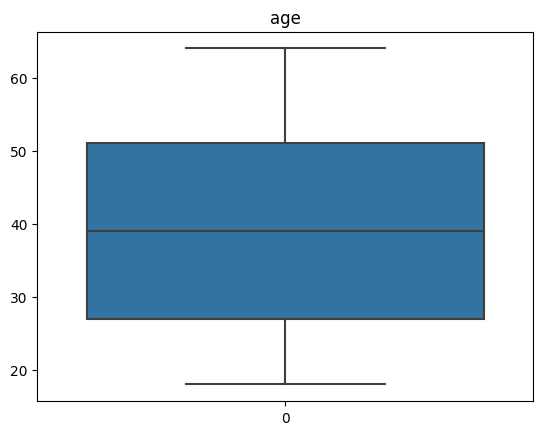

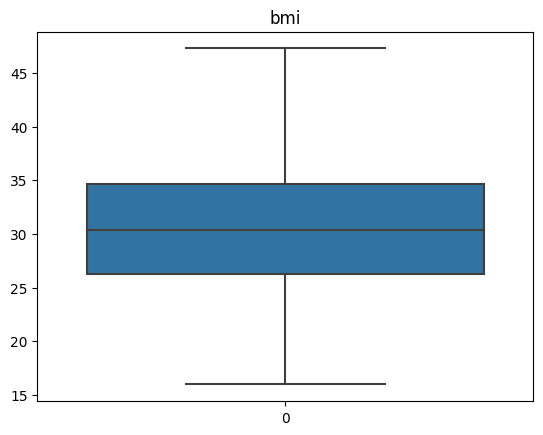

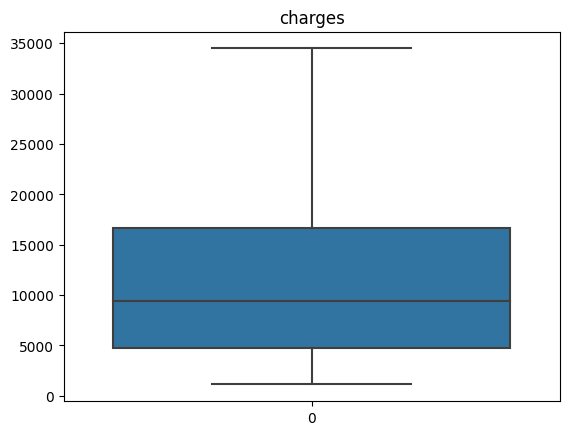

In [179]:
for col in num_cols:
    plt.title(col)
    sns.boxplot(df[col])
    plt.show(block=True)

In [180]:
# Özellik mühendisliği
# BMI < 18.5 - underweight
# 18.5 <= BMI < 25 - healthy weight
# 25 <= BMI < 30 - overweight
# BMI >= 30 - obesity

df["New_BMI"] = pd.cut(x=df["bmi"], bins=[0, 18.5, 24.9, 29.9, 100], labels = ["Underweight", "Healthy", "Overweight", "Obesity"])

In [181]:
df["New_BMI"].head()

0    Overweight
1       Obesity
2       Obesity
3       Healthy
4    Overweight
Name: New_BMI, dtype: category
Categories (4, object): ['Underweight' < 'Healthy' < 'Overweight' < 'Obesity']

In [182]:
# BMI ve Yaş kombinasyonuna göre yeni değişkenler oluşturuyoruz.
conditions = [
    (df["bmi"] < 18.5) & (df["age"] < 18),  # Underweight and young
    (df["bmi"] < 18.5) & (df["age"] >= 18) & (df["age"] < 50),  # Underweight and mature
    (df["bmi"] < 18.5) & (df["age"] >= 50),  # Underweight and senior
    (df["bmi"] >= 18.5) & (df["bmi"] < 25) & (df["age"] < 18),  # Healthy and young
    (df["bmi"] >= 18.5) & (df["bmi"] < 25) & (df["age"] >= 18) & (df["age"] < 50),  # Healthy and mature
    (df["bmi"] >= 18.5) & (df["bmi"] < 25) & (df["age"] >= 50),  # Healthy and senior
    (df["bmi"] >= 25) & (df["bmi"] < 30) & (df["age"] < 18),  # Overweight and young
    (df["bmi"] >= 25) & (df["bmi"] < 30) & (df["age"] >= 18) & (df["age"] < 50),  # Overweight and mature
    (df["bmi"] >= 25) & (df["bmi"] < 30) & (df["age"] >= 50),  # Overweight and senior
    (df["bmi"] >= 30) & (df["age"] < 18),  # Obesity and young
    (df["bmi"] >= 30) & (df["age"] >= 18) & (df["age"] < 50),  # Obesity and mature
    (df["bmi"] >= 30) & (df["age"] >= 50)  # Obesity and senior
]

choices = [
    "Underweight and young",
    "Underweight and mature",
    "Underweight and senior",
    "Healthy and young",
    "Healthy and mature",
    "Healthy and senior",
    "Overweight and young",
    "Overweight and mature",
    "Overweight and senior",
    "Obesity and young",
    "Obesity and mature",
    "Obesity and senior"
]

df["New_Age_and_BMI"] = np.select(conditions, choices)

In [183]:
df["New_Age_and_BMI"].head()

0    Overweight and mature
1       Obesity and mature
2       Obesity and mature
3       Healthy and mature
4    Overweight and mature
Name: New_Age_and_BMI, dtype: object

In [184]:
df.head(10)

,age,sex,bmi,children,smoker,region,charges,New_BMI,New_Age_and_BMI
0,19,female,27.9000,0,yes,southwest,16884.9240,Overweight,Overweight and mature
1,18,male,33.7700,1,no,southeast,1725.5523,Obesity,Obesity and mature
2,28,male,33.0000,3,no,southeast,4449.4620,Obesity,Obesity and mature
3,33,male,22.7050,0,no,northwest,21984.4706,Healthy,Healthy and mature
4,32,male,28.8800,0,no,northwest,3866.8552,Overweight,Overweight and mature
5,31,female,25.7400,0,no,southeast,3756.6216,Overweight,Overweight and mature
6,46,female,33.4400,1,no,southeast,8240.5896,Obesity,Obesity and mature
7,37,female,27.7400,3,no,northwest,7281.5056,Overweight,Overweight and mature
8,37,male,29.8300,2,no,northeast,6406.4107,Overweight,Overweight and mature
9,60,female,25.8400,0,no,northwest,28923.1369,Overweight,Overweight and senior


In [185]:
df["New_Age_and_BMI"].value_counts()

Obesity and mature        473
Overweight and mature     288
Obesity and senior        234
Healthy and mature        176
Overweight and senior      98
Healthy and senior         49
Underweight and mature     16
Underweight and senior      4
Name: New_Age_and_BMI, dtype: int64

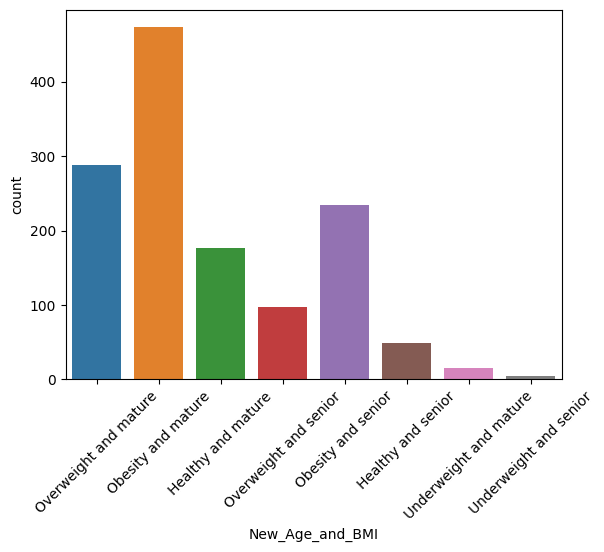

In [186]:
sns.countplot(x=df["New_Age_and_BMI"], data=df)
plt.xticks(rotation=45)
plt.show()

In [187]:
# Encoding işlemleri
def label_encoder(dataframe,binary_col):
    labelencoder=LabelEncoder()
    dataframe[binary_col]=labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [188]:
binary_cols=[col for col in df.columns if df[col].dtype not in [int,float] and df[col].nunique()==2]

In [189]:
binary_cols

['sex', 'smoker']

In [190]:
for col in binary_cols:
    df=label_encoder(df,col)

In [191]:
def one_hot_encoder(dataframe,cat_cols,drop_first=False):
    dataframe=pd.get_dummies(dataframe,columns=cat_cols,drop_first=drop_first)
    return dataframe

In [192]:
ohe_cols=[col for col in df.columns if 10>=df[col].nunique()>2]

In [193]:
ohe_cols

['children', 'region', 'New_BMI', 'New_Age_and_BMI']

In [194]:
df=one_hot_encoder(df,ohe_cols,drop_first=True)

In [195]:
df.head()

,age,sex,bmi,smoker,charges,children_1,children_2,children_3,children_4,children_5,region_northwest,region_southeast,region_southwest,New_BMI_Healthy,New_BMI_Overweight,New_BMI_Obesity,New_Age_and_BMI_Healthy and senior,New_Age_and_BMI_Obesity and mature,New_Age_and_BMI_Obesity and senior,New_Age_and_BMI_Overweight and mature,New_Age_and_BMI_Overweight and senior,New_Age_and_BMI_Underweight and mature,New_Age_and_BMI_Underweight and senior
0,19,0,27.9000,1,16884.9240,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
1,18,1,33.7700,0,1725.5523,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
2,28,1,33.0000,0,4449.4620,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
3,33,1,22.7050,0,21984.4706,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,32,1,28.8800,0,3866.8552,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0


In [196]:
# Özellik ölçeklendirme
for col in num_cols:
    transformer=RobustScaler().fit(df[[col]])
    df[col]=transformer.transform(df[[col]])

In [197]:
df.head()

,age,sex,bmi,smoker,charges,children_1,children_2,children_3,children_4,children_5,region_northwest,region_southeast,region_southwest,New_BMI_Healthy,New_BMI_Overweight,New_BMI_Obesity,New_Age_and_BMI_Healthy and senior,New_Age_and_BMI_Obesity and mature,New_Age_and_BMI_Obesity and senior,New_Age_and_BMI_Overweight and mature,New_Age_and_BMI_Overweight and senior,New_Age_and_BMI_Underweight and mature,New_Age_and_BMI_Underweight and senior
0,-0.8333,0,-0.2977,1,0.6305,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
1,-0.8750,1,0.4013,0,-0.6434,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
2,-0.4583,1,0.3096,0,-0.4145,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
3,-0.2500,1,-0.9163,0,1.0591,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,-0.2917,1,-0.1810,0,-0.4635,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0


In [198]:
# Bağımlı ve bağımsız değişkenlerin belirlenmesi
y = df['charges']
X = df.drop(["charges"], axis=1)

In [200]:
# Train ve test setinin bölünmesi
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=17)

In [201]:
models = [("LR", LinearRegression()),
          ("KNN", KNeighborsRegressor()),
          ("CART", DecisionTreeRegressor()),
          ("RF", RandomForestRegressor()),
          ("GBM", GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective="reg:squarederror")),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]

In [ ]:
for name, regressor in models:
  rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring= "neg_mean_squared_error")))
  print(f"RMSE :  {round(rmse,4)} ({name})")

# RMSE :  0.4254 (LR)
# RMSE :  0.5076 (KNN)
# RMSE :  0.5525 (CART)
# RMSE :  0.3956 (RF)
# RMSE :  0.3671 (GBM)
# RMSE :  0.4347 (XGBoost)
# RMSE :  0.3856 (LightGBM)
# RMSE :  0.3847 (CatBoost)

In [205]:
hyperparameters = [
    ("RF", RandomForestRegressor(), {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]}),
    ("GBM", GradientBoostingRegressor(), {"n_estimators": [50, 100, 200], "max_depth": [3, 10, 20]}),
    ("XGBoost", XGBRegressor(objective='reg:squarederror'), {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 7]}),
    ("LightGBM", LGBMRegressor(), {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 7]}),
    ("CatBoost", CatBoostRegressor(verbose=False), {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 7]})]

In [ ]:
# Grid Search ile en iyi parametreleri bulma ve modeli eğitme
for name, model, param_grid in hyperparameters:
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X, y)

    best_params = grid_search.best_params_
    best_score = np.sqrt(-grid_search.best_score_)
    print(f"Best Parameters for {name}: {best_params}")
    print(f"Best RMSE: {round(best_score, 4)}")

# Best Parameters for RF: {'max_depth': 10, 'n_estimators': 200}
# Best RMSE: 0.3916

# Best Parameters for GBM: {'max_depth': 3, 'n_estimators': 50}
# Best RMSE: 0.3601

# Best Parameters for XGBoost: {'max_depth': 3, 'n_estimators': 50}
# Best RMSE: 0.3723

# Best Parameters for LightGBM: {'max_depth': 3, 'n_estimators': 50}
# Best RMSE: 0.3577

# Best Parameters for CatBoost: {'max_depth': 3, 'n_estimators': 100}
# Best RMSE: 0.3678